# TODO

- ~~noisy~~
- optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf

- benchmark + proc approx?
- paralelni
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim

- kernely
- acquisition funkce

- matern kernel wtf???
- zkusit jestli torch.lbfgs je rychlejsi?

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernels import SquaredExp, RationalQuadratic, Linear
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [6]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

In [7]:
x, y = np.meshgrid([1, 2], [4, 5]) 
x * y

array([[ 4,  8],
       [ 5, 10]])

SquaredExp(l=1, sigma=1)
RationalQuadratic(sigma=1, l=1, alpha=1)


AxisError: axis 2 is out of bounds for array of dimension 0

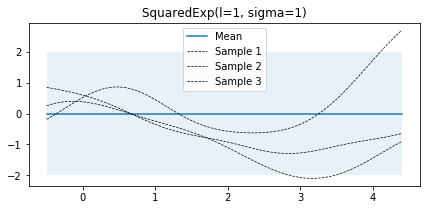

In [10]:
for k in [SquaredExp(), RationalQuadratic()]: #, Linear()]:
    print(k)
    GaussianProcess(kernel=k).plot_prior(X)

In [ ]:
for kernel in [RationalQuadratic(alpha=0.005), RationalQuadratic(), SquaredExp()]: #, Linear()]:
    GaussianProcess(kernel=kernel).with_noise(.02)\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0)

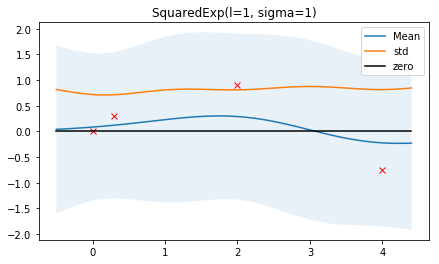

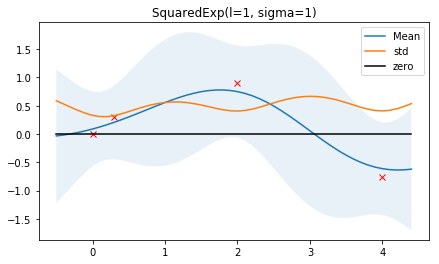

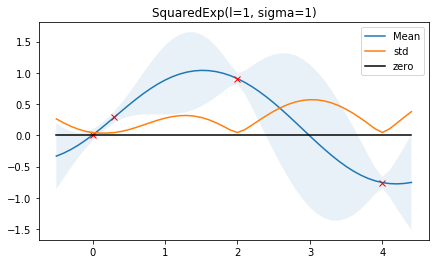

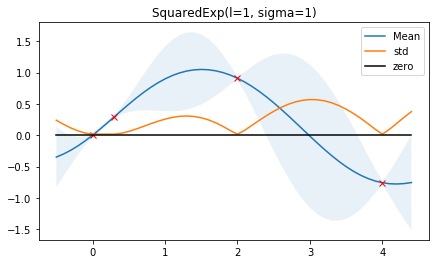

In [11]:
for noise in [2, 0.2, 0.002, 0.0002]:
    gp = GaussianProcess().with_noise(noise).posterior(X, X_train, y_train)
    plt.figure(figsize=(7,4))
    gp.plot_posterior(num_samples=0, figure=False)
    plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
    plt.plot(X, np.zeros_like(X), label="zero", c="k")
    plt.legend()
    plt.show()

## Kernel params

Found optimal params [0.66273494]


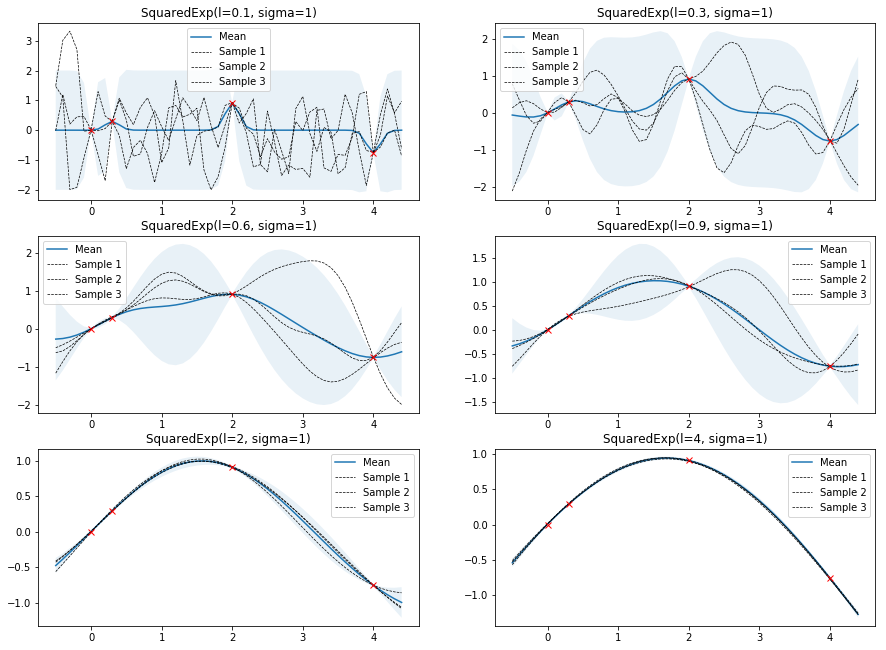

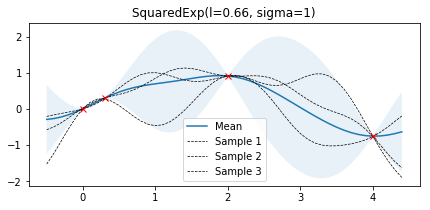

In [30]:
params = [0.1, 0.3, 0.6, 0.9, 2, 4]

gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

gp.fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior()

In [28]:
print(compute_optimized_kernel(kernel, X_train, y_train)) 

Found optimal params [0.66273494]
SquaredExp(l=0.66, sigma=1)


## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

Found optimal params [0.66273494]
SquaredExp(l=0.66, sigma=1)
Found optimal params [0.66273494]


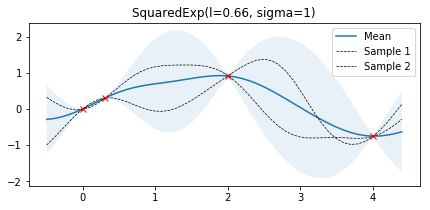

In [27]:
# Example with broken kernel optimization

X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)
kernel = SquaredExp(l=77.26, sigma=1)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

print(compute_optimized_kernel(kernel, X_train, y_train)) # ??? wtf

# plt.plot(X, np.zeros_like(X))
# plt.scatter(X_train, y_train)

a = GaussianProcess().fit(X_train, y_train)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)  # broken kernel opt

In [21]:
X = np.arange(-5, 5, 0.1)

noise = 0.2

# Noisy training data
X_train = np.arange(-3, 4, 1)
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

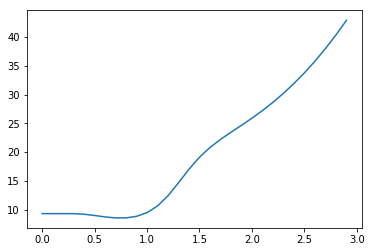

In [24]:
from myopt.kernel_opt import plot_kernel_loss
plot_kernel_loss(SquaredExp(), X_train, y_train, xmax=3)

Found optimal params [0.87452301]


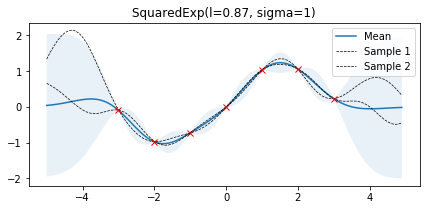

In [300]:
GaussianProcess().fit(X_train, y_train)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

In [241]:
compute_optimized_kernel(a.kernel, X_train, y_train)

SquaredExp(l=0.8, sigma=1)

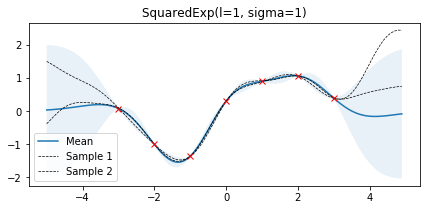

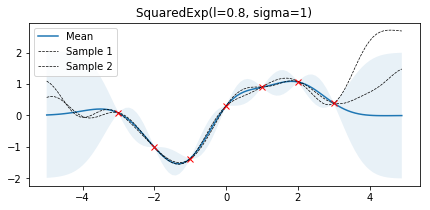

In [242]:
a = GaussianProcess().fit(X_train, y_train)\
        .posterior(X).plot_posterior(num_samples=2)

b = a.optimize_kernel().posterior(X).plot_posterior(num_samples=2)

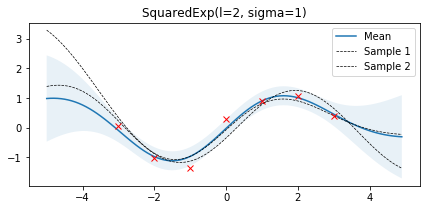

In [243]:
k = GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior(num_samples=2).kernel

In [244]:
compute_optimized_kernel(SquaredExp(2), X_train, y_train)

SquaredExp(l=0.8, sigma=1)

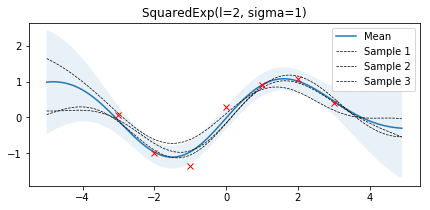

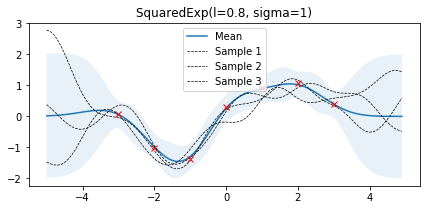

In [245]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

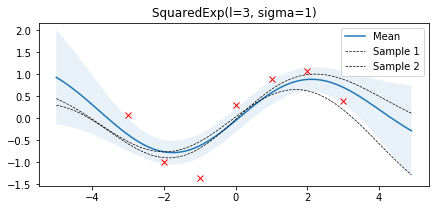

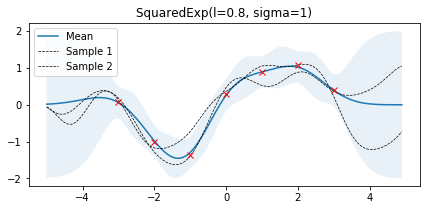

In [246]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([3, 1]).posterior(X).plot_posterior(num_samples=2)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

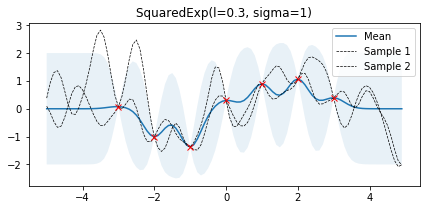

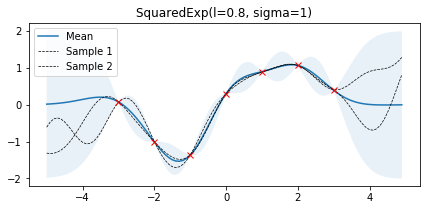

In [247]:
GaussianProcess().fit(X_train, y_train)\
        .with_kernel_params([0.3, 1]).posterior(X).plot_posterior(num_samples=2)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

## More general alternative to `np.meshgrid`

In [248]:
a = np.array([1,2]).reshape(-1, 1)
b = np.array([4,5]).reshape(1, -1)

a + b

array([[5, 6],
       [6, 7]])

In [249]:
a * b

array([[ 4,  5],
       [ 8, 10]])

## but how do I do this with tensordot on tensors?

In [250]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

In [251]:
np.sqrt(((a - b) ** 2).sum(axis=2))

array([[3., 4.],
       [2., 3.]])

In [252]:
np.linalg.norm(a - b, axis=2)

array([[3., 4.],
       [2., 3.]])

In [253]:
np.tensordot(a, b, axes=2)

array([[4, 0],
       [8, 0]])

In [254]:
# This seems to work, but why are there the extra dimensions?
np.tensordot(a, b, axes=[2,2])

array([[[[ 4,  5]]],


       [[[ 8, 10]]]])

In [255]:
np.tensordot(a, b, axes=((1, 2), (0, 2)))

array([[ 4,  5],
       [ 8, 10]])

In [256]:
z = np.zeros((a.shape[0], b.shape[1]))

for i in range(a.shape[0]):
    for j in range(b.shape[1]): 
        z[i, j] = a[i, 0] @ b[0, j]

z

array([[ 4.,  5.],
       [ 8., 10.]])

In [257]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

za = np.zeros_like(a)
zb = np.zeros_like(b)

aa = a + zb
bb = b + za

np.tensordot(aa, bb, axes=((1,2), (0,2)))
# array([[ 8,  0],
#        [16,  0]])

array([[ 8, 10],
       [16, 20]])

## Workaround with one loop

In [258]:
a = np.array([[1,0],[2,0]])
b = np.array([[4,0],[5,0]])

bb = b.T

rows = []

for i in range(a.shape[0]):
    rows.append(a[i] @ bb)

res = np.array(rows)

In [259]:
np.array(rows)

array([[ 4,  5],
       [ 8, 10]])

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [260]:
from myopt.bayesian_optimization import bo_minimize
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location

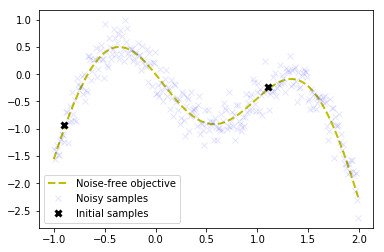

In [290]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true, 0)
%matplotlib inline
# Plot optimization objective with noise level 
plt.plot(X_true, y_true, 'y--', lw=2, label='Noise-free objective')
plt.plot(X_true, f(X_true), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Found optimal params [1.95778173]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]
Found optimal params [1.e-05]


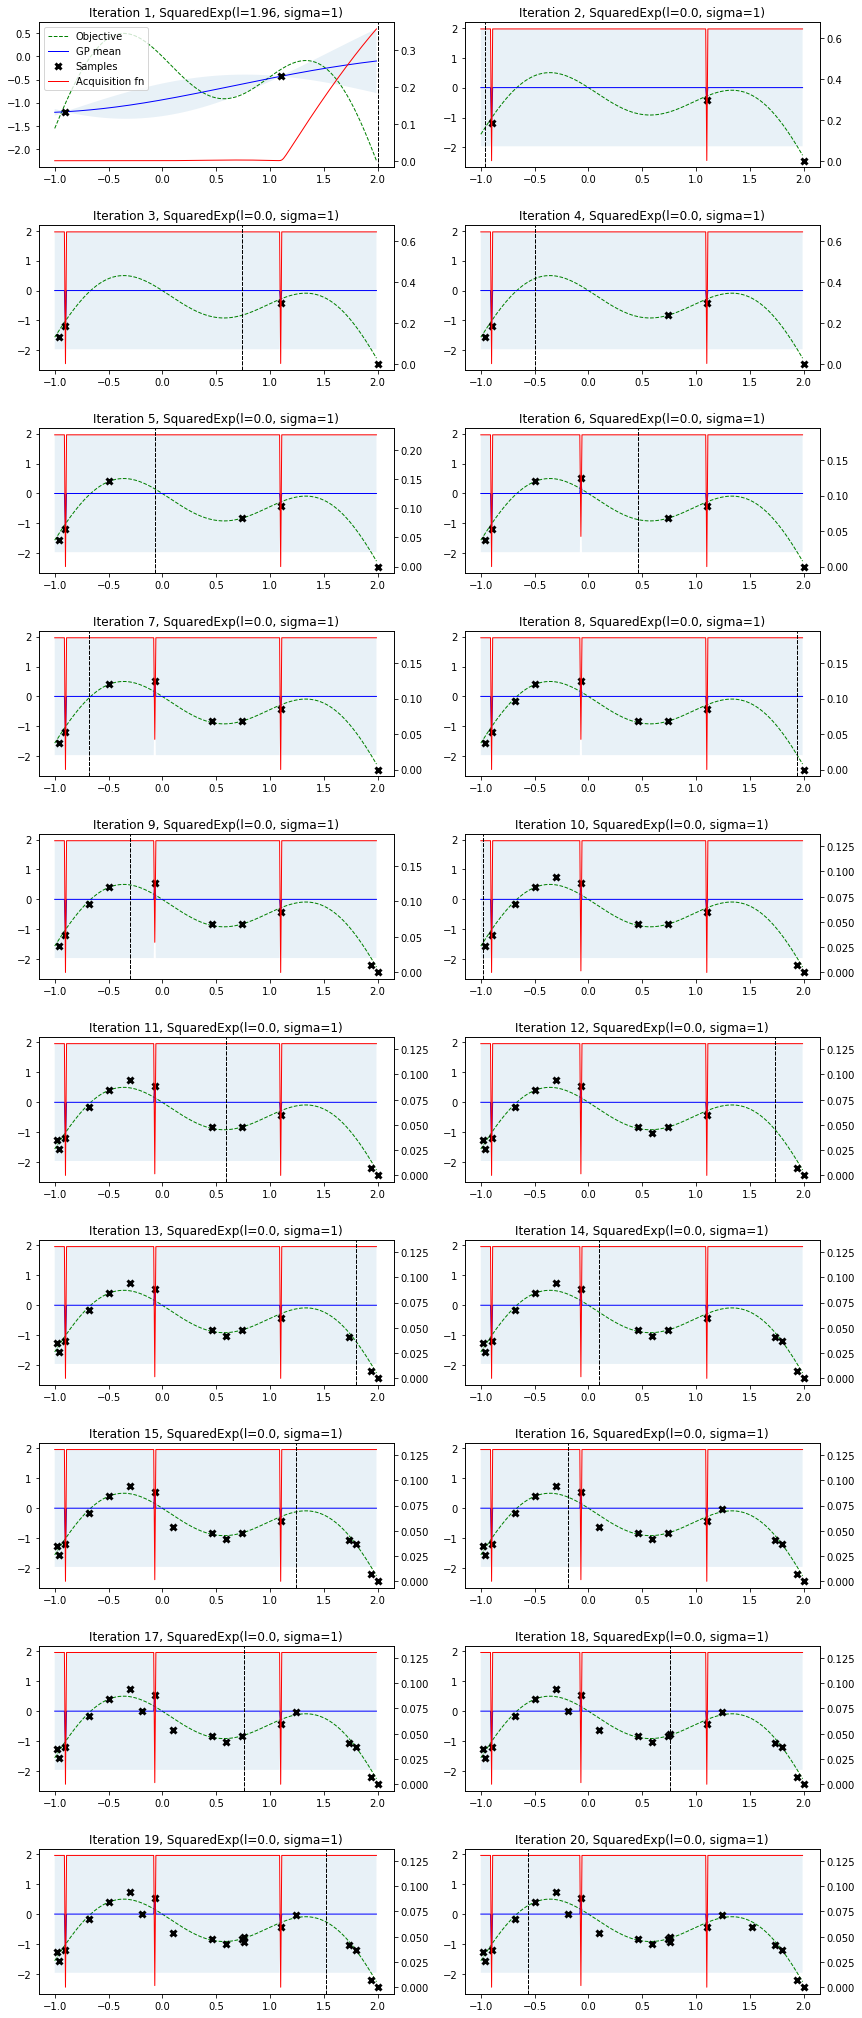

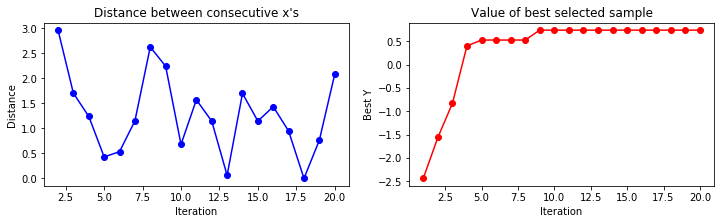

In [264]:
bo_minimize(f, noise, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=20, optimize_kernel=True)

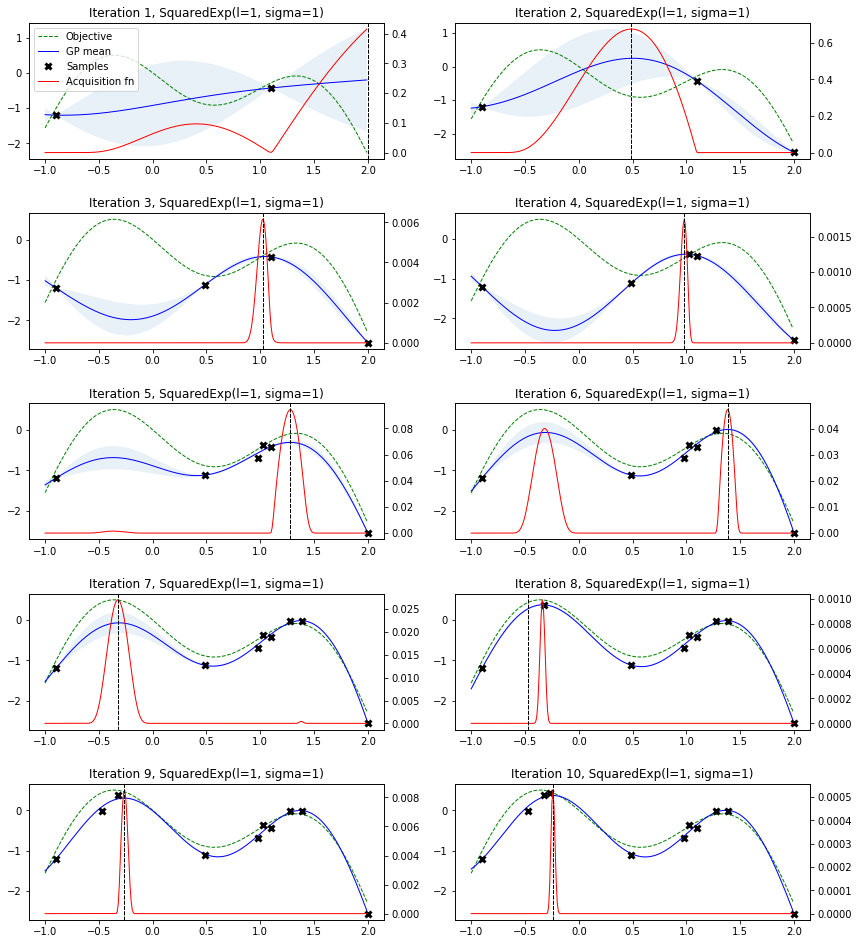

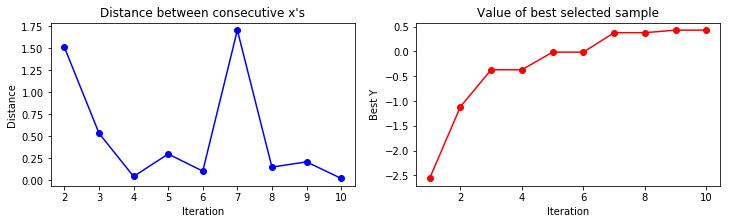

In [263]:
bo_minimize(f, noise, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=10, optimize_kernel=False)

# Matrix inverse timing

- zkompilovat numpy s AVX

In [28]:
import torch

In [29]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = np.random.randn(n, n)
    %time inv(m)

Wall time: 0 ns
Wall time: 486 µs
Wall time: 39.4 ms
Wall time: 238 ms
Wall time: 721 ms
Wall time: 1.49 s


In [30]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n))
    %time torch.inverse(m)

Wall time: 0 ns
Wall time: 499 µs
Wall time: 25.5 ms
Wall time: 165 ms
Wall time: 516 ms
Wall time: 1.07 s


In [31]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n)).cuda()
    %time torch.inverse(m)

Wall time: 468 ms
Wall time: 11 ms
Wall time: 50.9 ms
Wall time: 152 ms
Wall time: 327 ms
Wall time: 582 ms


## GP benchmarks

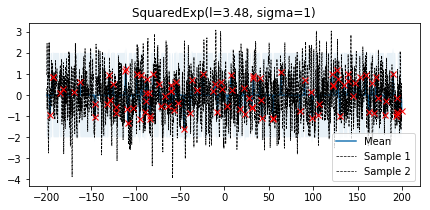

In [11]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%prun GaussianProcess().fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(num_samples=2)


Wall time: 2.45 s
Wall time: 17.9 s


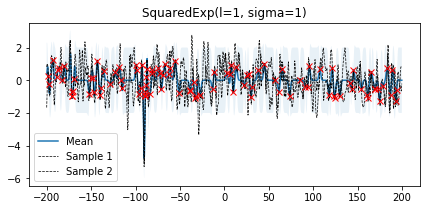

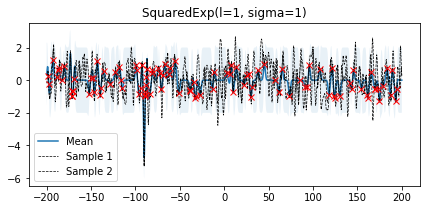

In [36]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

X = np.arange(-200, 200, 0.1)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

# LOL np.ndarray

Broken SquaredExp optimiation

![broken img](https://i.imgur.com/Oa49O2R.png)

[0.66273494]


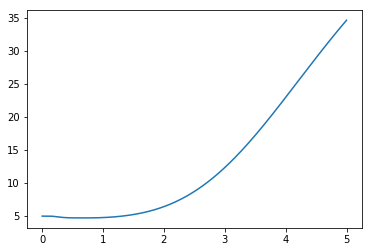

In [31]:
from myopt.kernels import SquaredExp
import numpy as np
from numpy.linalg import inv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

kernel = SquaredExp(l=77.26, sigma=1)

X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

def step(theta):
    noise_level = 0.1

    kernel = SquaredExp()

    noise = noise_level ** 2 * np.eye(len(X_train))
    K = kernel.with_params(theta)(X_train, X_train) + noise

    t1 = 0.5 * y_train.T @ inv(K) @ y_train
    t2 = 0.5 * np.linalg.det(K)
    t3 = 0.5 * len(X_train) * np.log(2 * np.pi)

    return t1 + t2 + t3

X = np.arange(0.001, 5, step=0.001)
thetas = []

for theta in X:
    thetas.append(step([theta]))

thetas = np.array(thetas)

res = minimize(step,
               np.array([1]),
               bounds=kernel.param_bounds(), method="L-BFGS-B")

print(res.x)

plt.plot(X, thetas)
plt.show()

In [3]:
import numpy as np
from numpy.linalg import inv

for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = np.random.randn(n, n)
    %time inv(m)

CPU times: user 294 µs, sys: 249 µs, total: 543 µs
Wall time: 249 µs
CPU times: user 7.42 ms, sys: 4.56 ms, total: 12 ms
Wall time: 5.77 ms
CPU times: user 197 ms, sys: 37.7 ms, total: 235 ms
Wall time: 66.7 ms
CPU times: user 1.01 s, sys: 85.4 ms, total: 1.1 s
Wall time: 319 ms
CPU times: user 3 s, sys: 169 ms, total: 3.17 s
Wall time: 975 ms
CPU times: user 6.49 s, sys: 265 ms, total: 6.76 s
Wall time: 2.08 s


In [6]:
import torch

for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n))
    %time torch.inverse(m)

CPU times: user 603 µs, sys: 741 µs, total: 1.34 ms
Wall time: 576 µs
CPU times: user 1.36 ms, sys: 3.59 ms, total: 4.96 ms
Wall time: 7.01 ms
CPU times: user 126 ms, sys: 53.1 ms, total: 179 ms
Wall time: 54.3 ms
CPU times: user 886 ms, sys: 40.4 ms, total: 926 ms
Wall time: 223 ms
CPU times: user 2.96 s, sys: 95.3 ms, total: 3.06 s
Wall time: 723 ms
CPU times: user 7.47 s, sys: 145 ms, total: 7.61 s
Wall time: 1.66 s


<IPython.core.display.Javascript object>


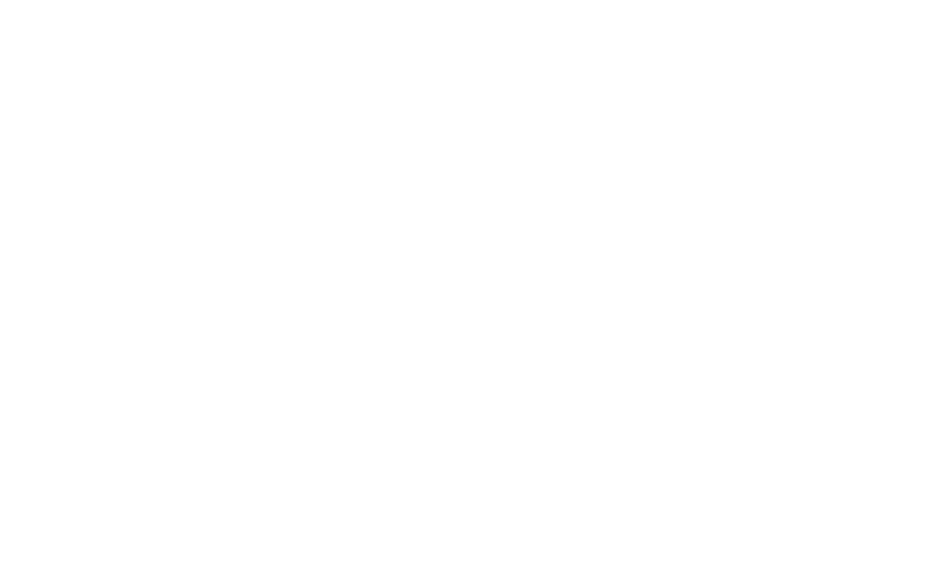

<IPython.core.display.Javascript object>


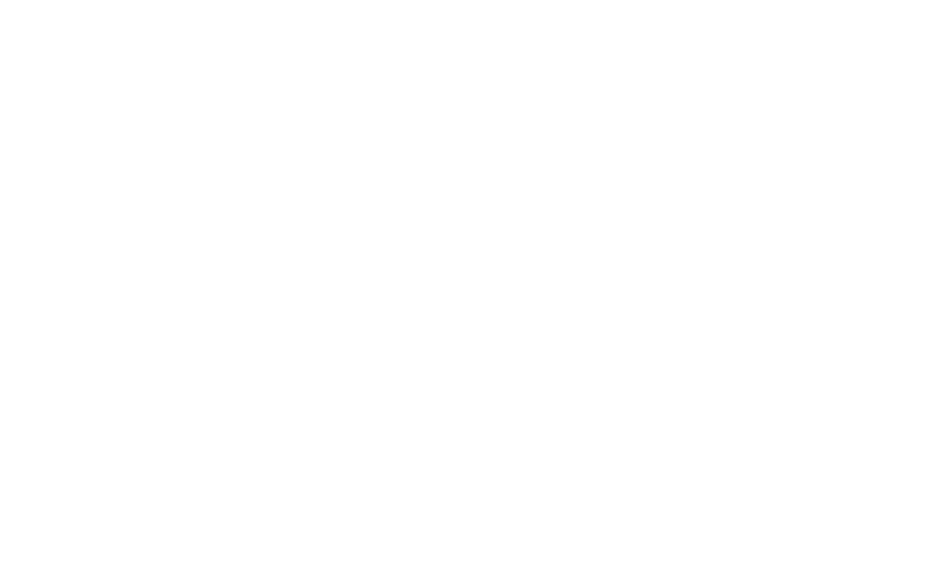

In [229]:
from myopt.plot import plot_gp_2D

noise_2d = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (100, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1)) + \
             noise_2d * np.random.randn(len(X_2d_train))

# plt.figure(figsize=(14,7))

# mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).posterior(X_2d).mu_std()

#plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "LOL it works", 1)
#plt.show()

mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()
# %matplotlib notebook

plt.figure(figsize=(13,8))
plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "w/ kernel optt", 1)
# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
#            f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

# res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
#                bounds=((1e-5, None), (1e-5, None)),
#                method='L-BFGS-B')

# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
#            f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

In [159]:
GaussianProcess().fit(X_2d_train, y_2d_train).posterior(X_2d).mu_std()

(1156,)